# CEX vs. DEX lending rates difference analysis

This is an example of analysing differences between CEX and DEX lending rates for the same or similar asset.
The notebook can be used to examine how efficient the markets are and how similar is the price action.

- In this notebook, we compare lending Binance `WETH` and `USDC` on AAVE to lending the same assets on Binance

- We compare annual rates at one hour intervals

## Summary

- Lending rate differences stay volatile over time, unlike price action differences which have gotten tighter over time. 
- ETH is becoming more and more expensive to borrow on Binance over time, meaning the lending rate difference for ETH is increasing.
- USDC has a much more volatile lending rate than ETH.
- Consistenly higher lending rates on Binance than Aave. This means it is cheaper to borrow on Aave (before considering gas or any other indirect costs).

# Parameters

Set up parameters we compare.


In [27]:
import pandas as pd
from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket

# Pair data description we load from Trading Strategy oracle
time_bucket = TimeBucket.h1

# Parquet file from binance data
start = pd.Timestamp("2023-07-16")
end = pd.Timestamp("2023-12-07")

# Load aave data

We load lending reserve data for two assets: WETH and USDC

In [28]:
from tradingstrategy.client import Client

client = Client.create_jupyter_client()

eth_reserve_id = 5
usdc_reserve_id = 3

aave_candles_eth = client.fetch_lending_candles_by_reserve_id(eth_reserve_id, time_bucket, start_time=start, end_time=end)
aave_candles_usdc = client.fetch_lending_candles_by_reserve_id(usdc_reserve_id, time_bucket, start_time=start, end_time=end)

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/alexurbs/.tradingstrategy


# Load Binance lending data

We also load the two same assets for the Binance lending data, WETH and USDC

In [29]:
from tradeexecutor.utils.binance import fetch_binance_dataset

binance_dataset = fetch_binance_dataset(
    ["ETHUSDT"],
    TimeBucket.h1,
    TimeBucket.h1,
    start.to_pydatetime(),
    end.to_pydatetime(),
    include_lending=True,
    #force_download=True,
)

# binance_candles_eth = binance_dataset.candles
binance_time_bucket = binance_dataset.time_bucket
binance_candles = binance_dataset.lending_candles.variable_borrow_apr.df

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

# Check data

Make sure all dataframes are in a format we expect.

In [30]:
from tradingstrategy.charting.candle_chart import validate_ohclv_dataframe

validate_ohclv_dataframe(aave_candles_eth)
validate_ohclv_dataframe(aave_candles_usdc)
validate_ohclv_dataframe(binance_candles)

assert binance_time_bucket == time_bucket, f"Loaded candles are for different time frame: {binance_time_bucket} vs {time_bucket}"

# Align data

Make sure both price feeds are aligned to the same time period.


In [31]:
aave_candles_eth = aave_candles_eth[start:end]
aave_candles_usdc = aave_candles_usdc[start:end]
binance_candles = binance_candles[start:end]

print(f"Time period {start} - {end}")
print(f"Aave ETH has {len(aave_candles_eth)} candles")
print(f"Aave USDC has {len(aave_candles_eth)} candles")
print(f"Aave in total has {len(aave_candles_eth) + len(aave_candles_usdc)} candles")
print(f"Binance has {len(binance_candles)} candles")


Time period 2023-07-16 00:00:00 - 2023-12-07 00:00:00
Aave ETH has 3457 candles
Aave USDC has 3457 candles
Aave in total has 6772 candles
Binance has 6910 candles


# Output mode

Set Plotly to static output mode, so that charts are readable on Github web interface.

In [32]:
from tradeexecutor.backtest.notebook import OutputMode, setup_charting_and_output
setup_charting_and_output(OutputMode.static, image_format="png")

# Visualise differences

Compare differences in `close` price.

With the charts, we can clearly see the premium placed on DEX lending rates compared to CEXs, with the difference constantly remaining significanly positive over time

In [33]:
import plotly.express as px

binance_candles_eth = binance_candles.loc[binance_candles["reserve_id"] == 1]
binance_candles_usdc = binance_candles.loc[binance_candles["reserve_id"] == 2]

close_diff_eth = binance_candles_eth["close"] - aave_candles_eth["close"]
close_diff_usdc = binance_candles_usdc["close"] - aave_candles_usdc["close"]

print('ETH comparison table')
comp_table_eth = pd.DataFrame({
    "Binance": binance_candles_eth["close"],
    "Aave": aave_candles_eth["close"],
    "Diff": close_diff_eth,
})
display(comp_table_eth.head())

print('USDC comparison table')
comp_table_usdc = pd.DataFrame({
    "Binance": binance_candles_usdc["close"],
    "Aave": aave_candles_usdc["close"],
    "Diff": close_diff_usdc,
})
comp_table_usdc.head()

ETH comparison table


Binance      Aave      Diff
timestamp                                       
2023-07-16 00:00:00   2.1024  1.945602  0.156798
2023-07-16 01:00:00   2.1024  1.945593  0.156807
2023-07-16 02:00:00   2.1024  1.945445  0.156955
2023-07-16 03:00:00   2.1024  1.949577  0.152823
2023-07-16 04:00:00   2.1024  1.949471  0.152929

USDC comparison table


Binance      Aave      Diff
timestamp                                        
2023-07-16 00:00:00  6.419985  7.714042 -1.294057
2023-07-16 01:00:00  6.419985  6.862007 -0.442022
2023-07-16 02:00:00  6.680230  6.188979  0.491251
2023-07-16 03:00:00  6.680230  5.532854  1.147376
2023-07-16 04:00:00  6.680230  6.351321  0.328909

In [34]:
max_difference_at = abs(close_diff_eth).idxmax()
max_difference = close_diff_eth[max_difference_at]
max_difference_rel = close_diff_eth[max_difference_at] / binance_candles_eth["close"][max_difference_at]
print(f"The largest lending rate divergence for ETH lending rates was {round(max_difference,2)} percentage points ({max_difference_rel * 100:.2f}%) at {max_difference_at}")

The largest lending rate divergence for ETH lending rates was 1.08 percentage points (34.60%) at 2023-10-02 23:00:00


In [35]:
max_difference_at = abs(close_diff_usdc).idxmax()
max_difference = close_diff_usdc[max_difference_at]
max_difference_rel = close_diff_usdc[max_difference_at] / binance_candles_usdc["close"][max_difference_at]
print(f"The largest lending rate divergence for UDSC lending rates was {round(max_difference, 2)} percentage points ({max_difference_rel * 100:.2f}%) at {max_difference_at}")

The largest lending rate divergence for UDSC lending rates was 26.52 percentage points (84.20%) at 2023-12-04 04:00:00


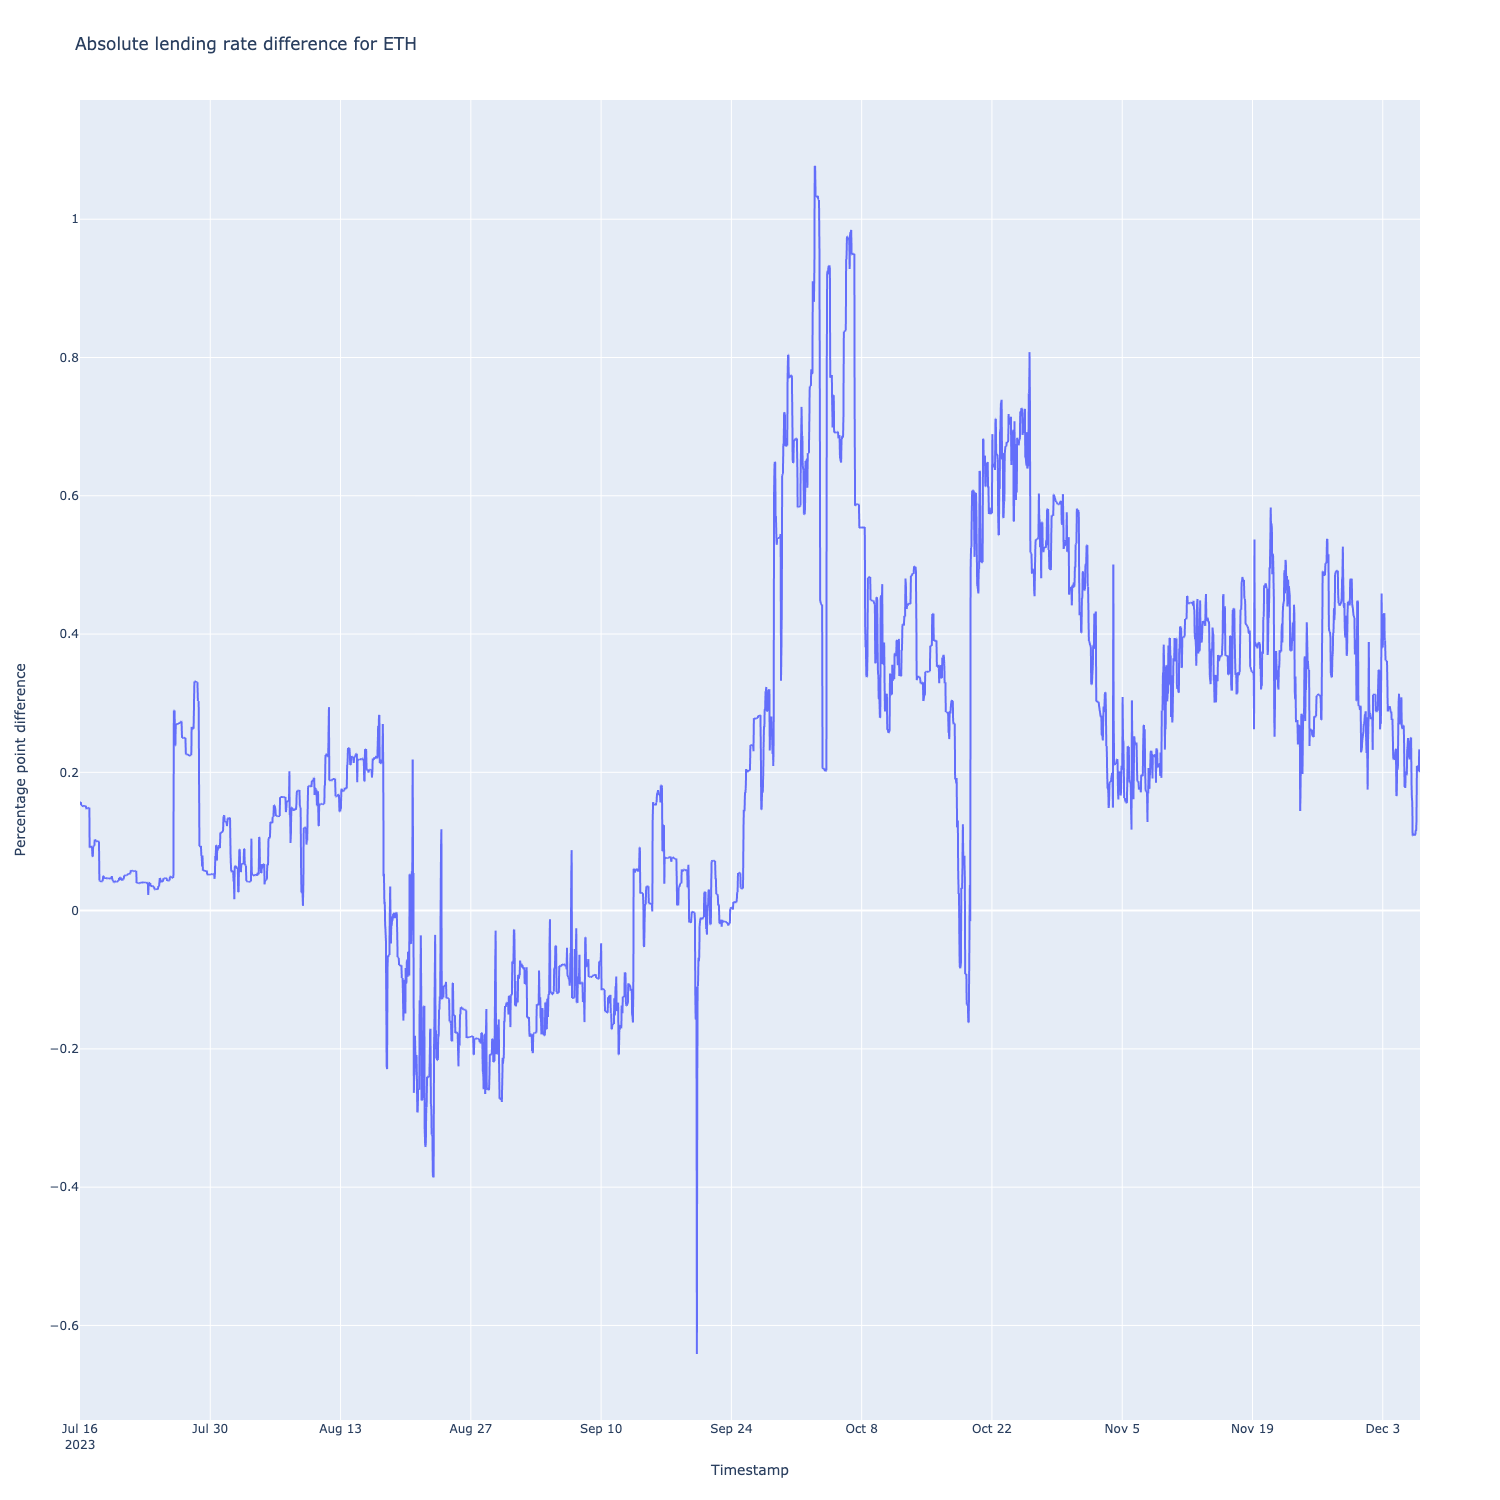

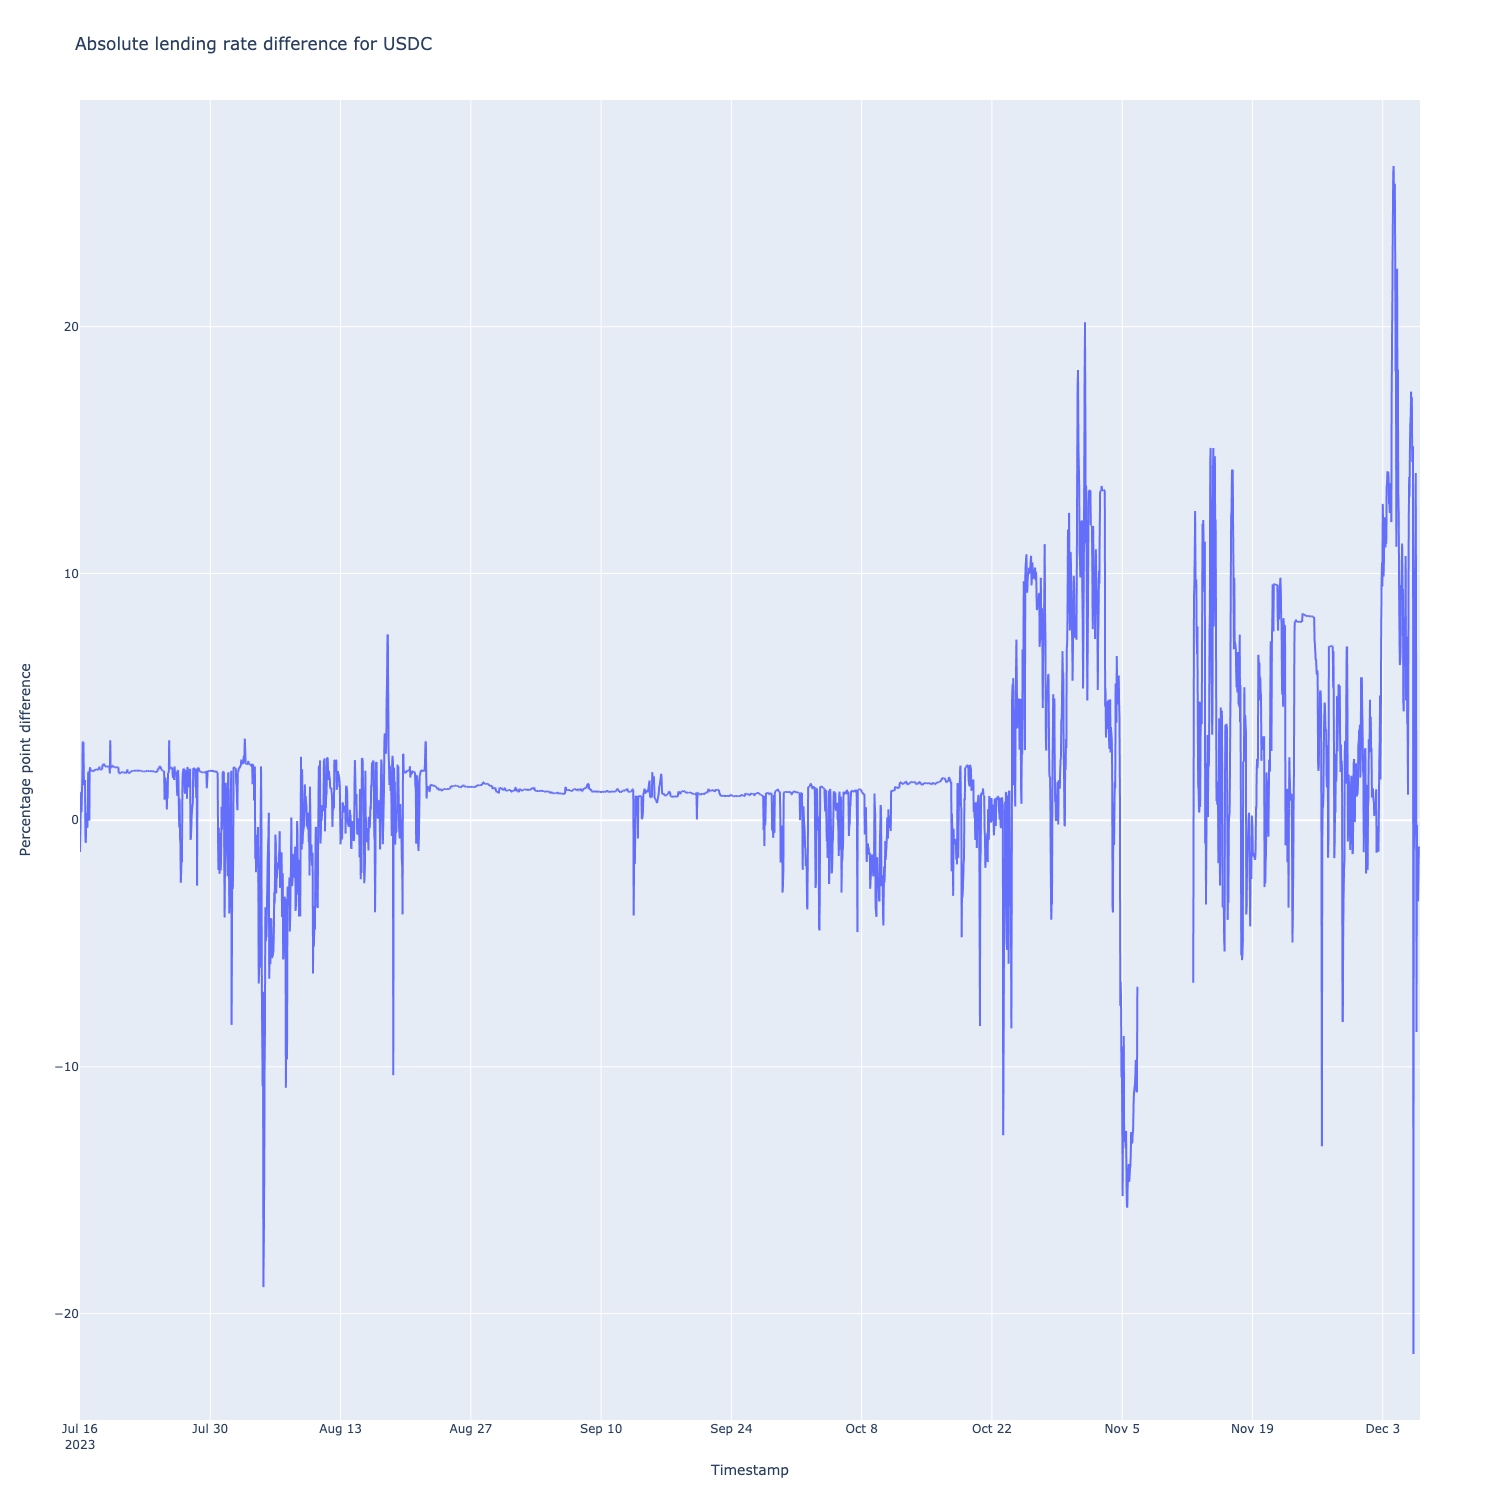

In [36]:
fig_eth = px.line(
    close_diff_eth,
    y=close_diff_eth,
    x=close_diff_eth.index,    
    title="Absolute lending rate difference for ETH",
)

fig_eth.update_yaxes(title="Percentage point difference")
fig_eth.update_xaxes(title="Timestamp")
fig_eth.show()


fig_usdc = px.line(
    close_diff_usdc,
    y=close_diff_usdc,
    x=close_diff_usdc.index,    
    title="Absolute lending rate difference for USDC",
)

fig_usdc.update_yaxes(title="Percentage point difference")
fig_usdc.update_xaxes(title="Timestamp")
fig_usdc.show()

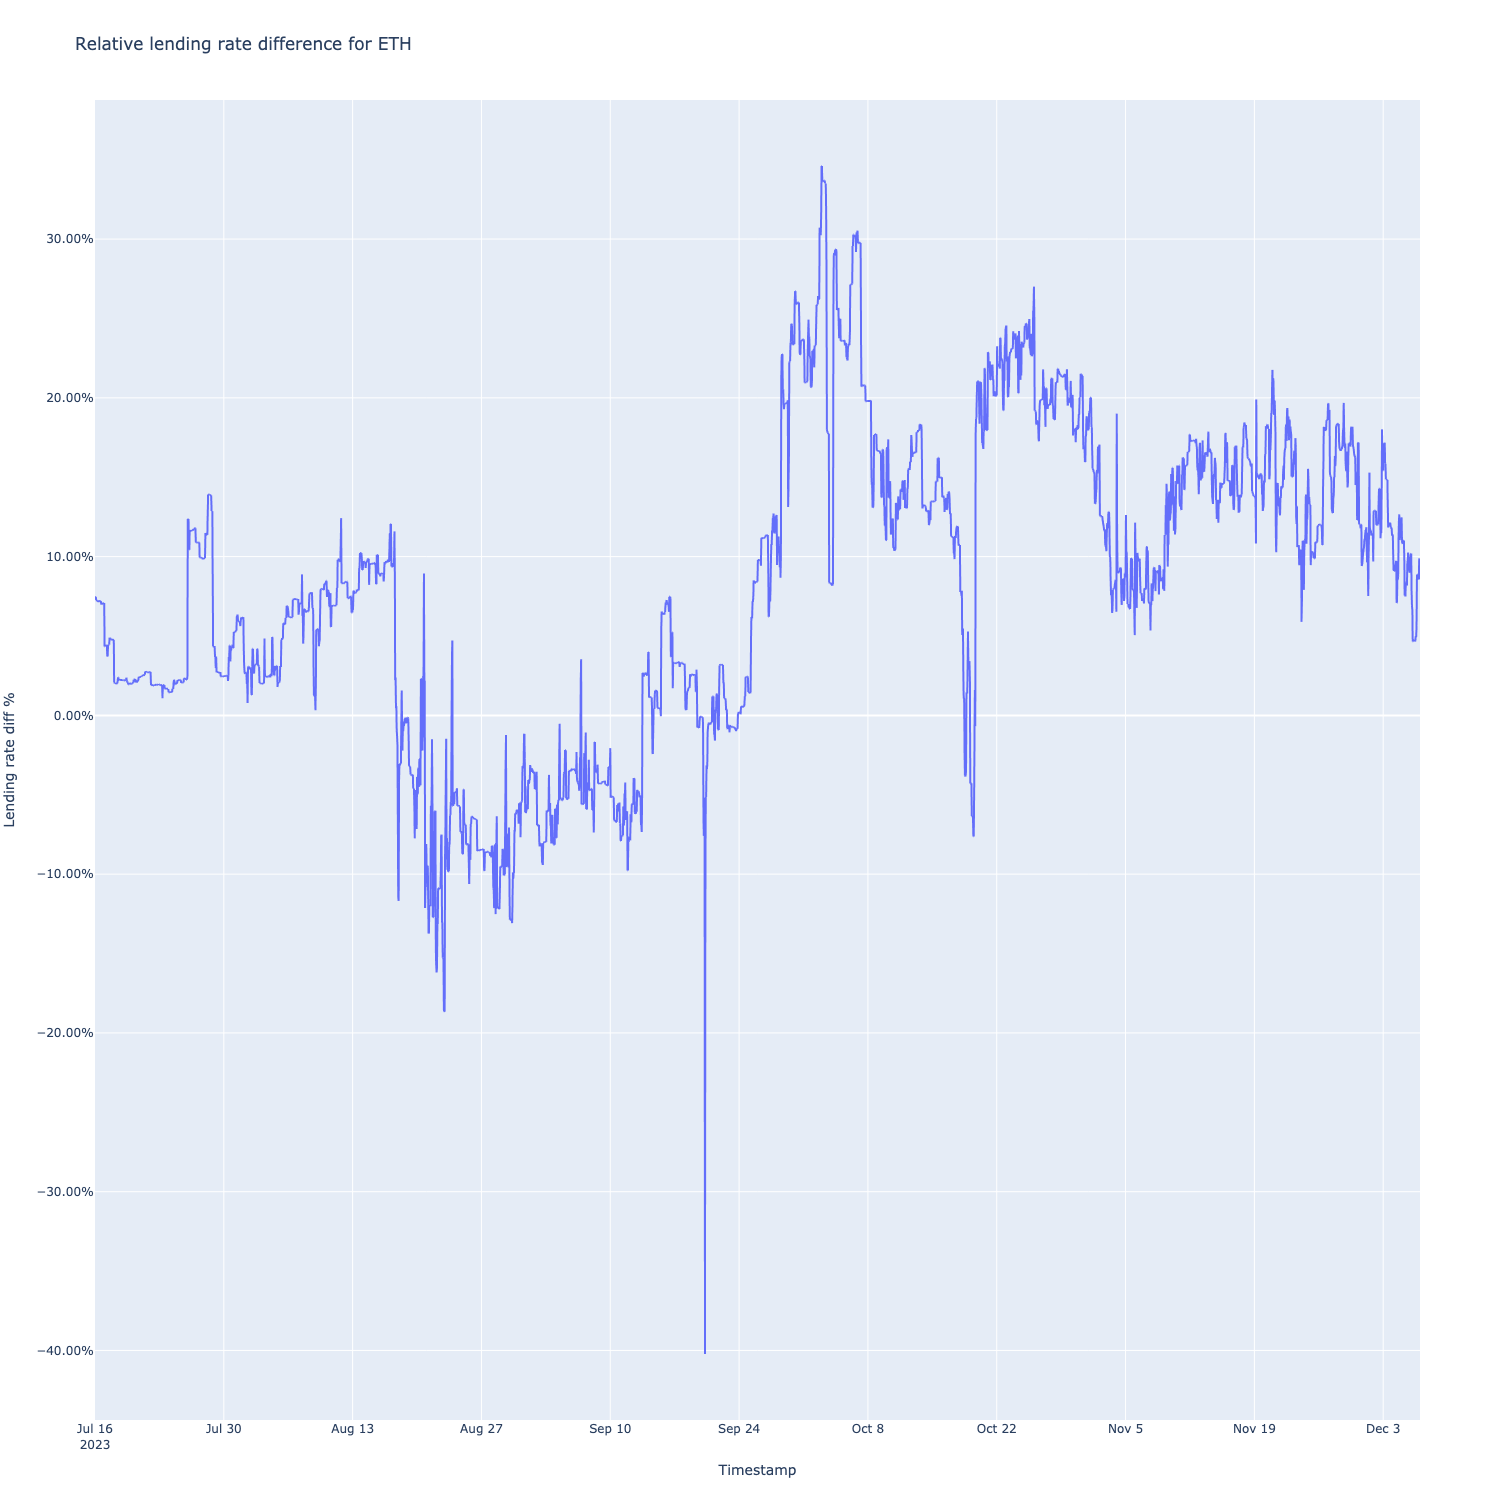

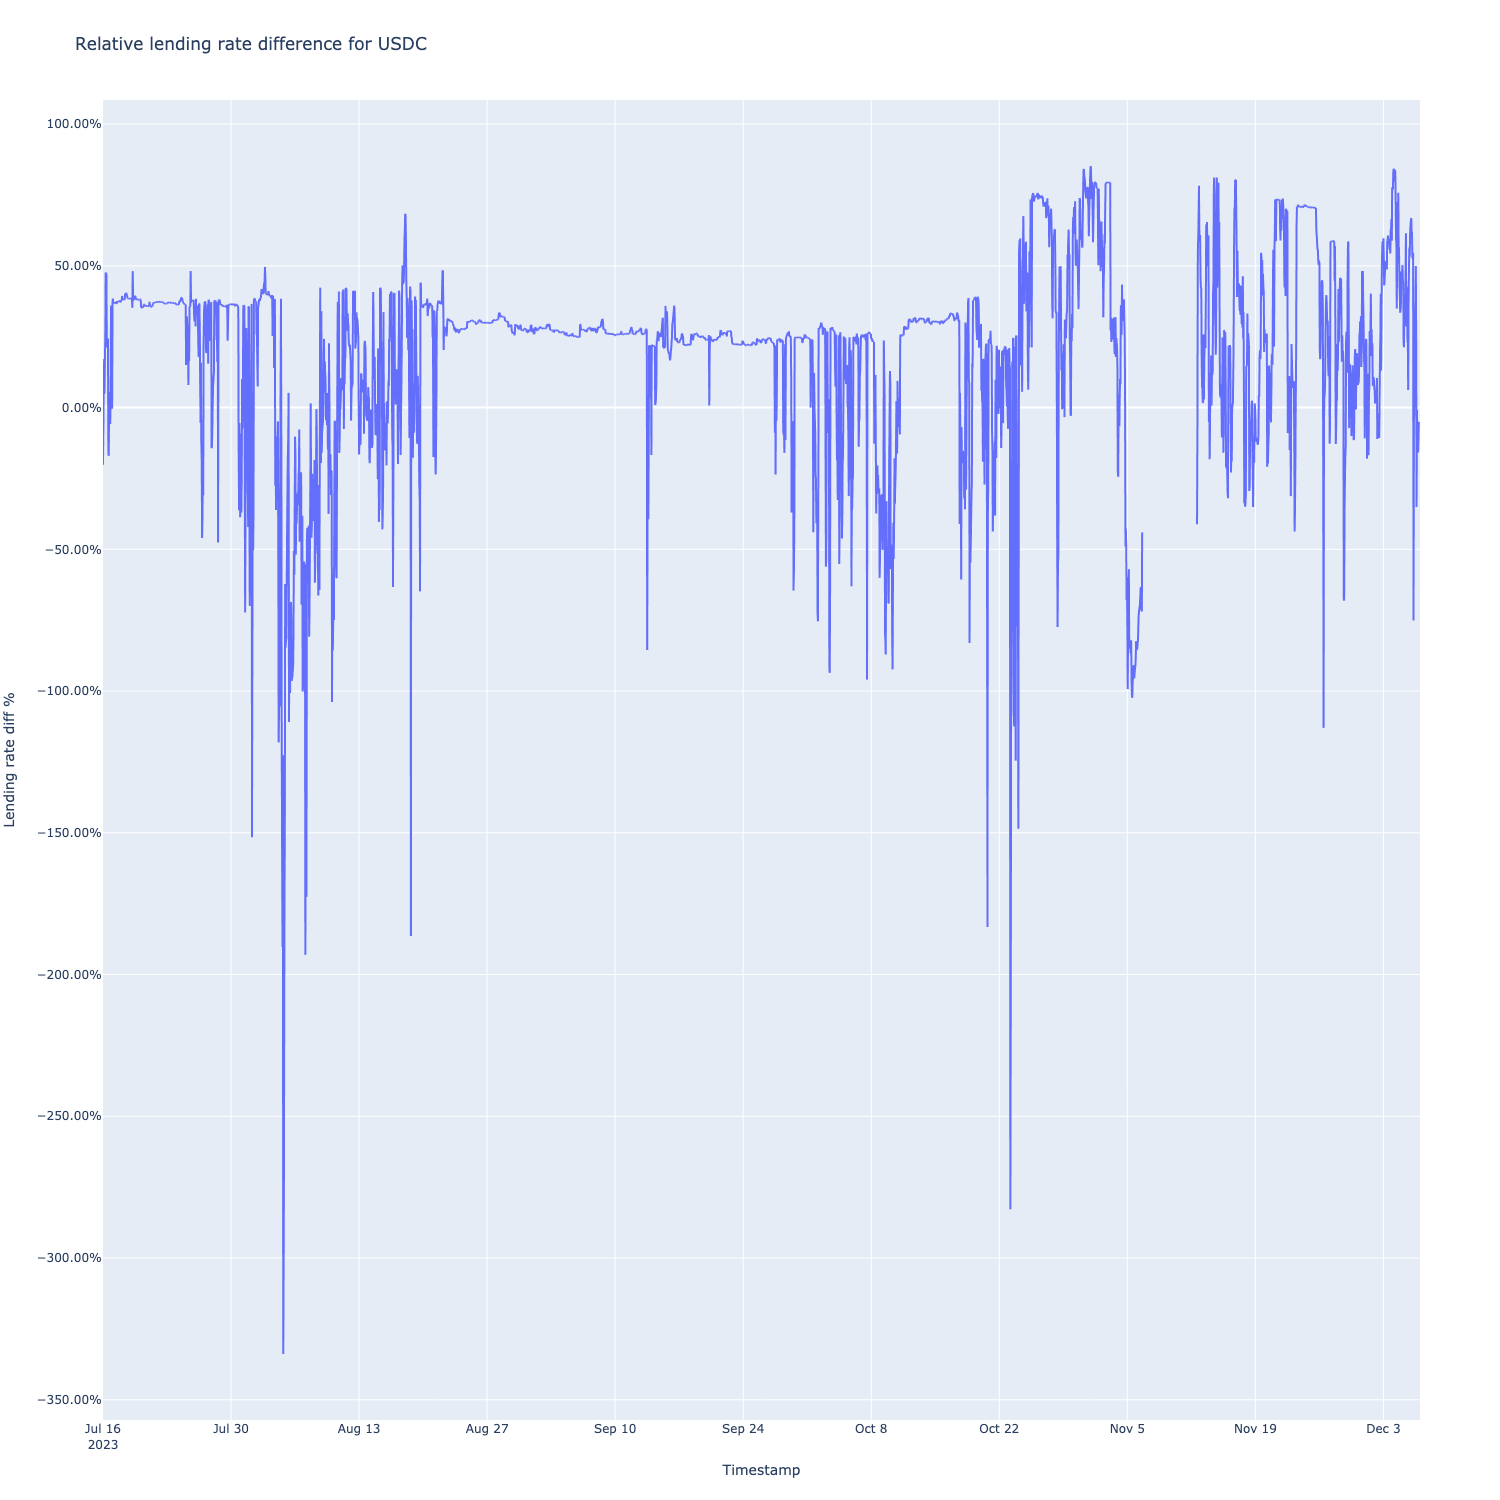

In [37]:
rel_diff_eth = close_diff_eth / binance_candles_eth["close"]

fig_eth = px.line(
    rel_diff_eth,
    y=rel_diff_eth,
    x=rel_diff_eth.index,
     title="Relative lending rate difference for ETH",
)

fig_eth.layout.yaxis.tickformat = ',.2%'

fig_eth.update_yaxes(title="Lending rate diff %")
fig_eth.update_xaxes(title="Timestamp")
fig_eth.show()

rel_diff_usdc = close_diff_usdc / binance_candles_usdc["close"]

fig_usdc = px.line(
    rel_diff_usdc,
    y=rel_diff_usdc,
    x=rel_diff_usdc.index,
     title="Relative lending rate difference for USDC",
)

fig_usdc.layout.yaxis.tickformat = ',.2%'

fig_usdc.update_yaxes(title="Lending rate diff %")
fig_usdc.update_xaxes(title="Timestamp")
fig_usdc.show()

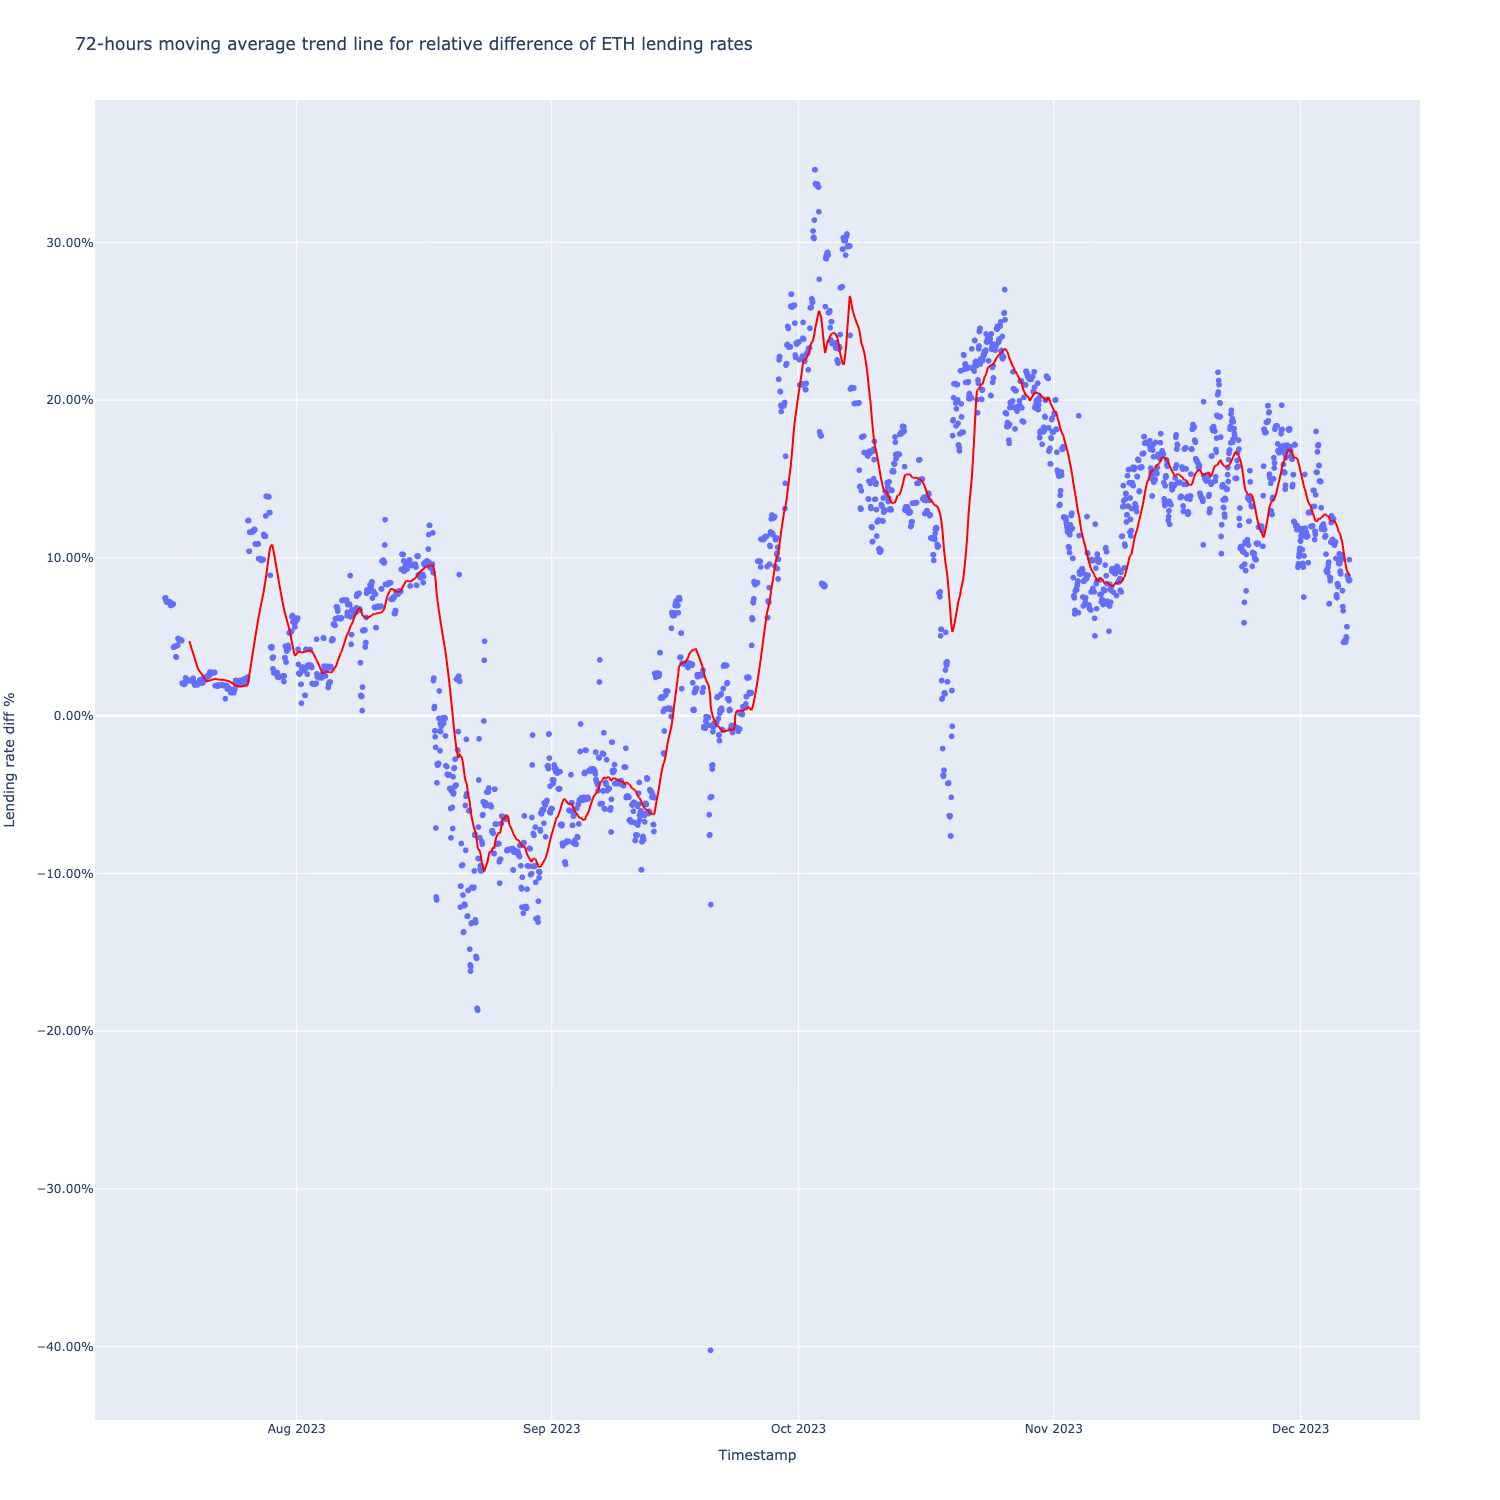

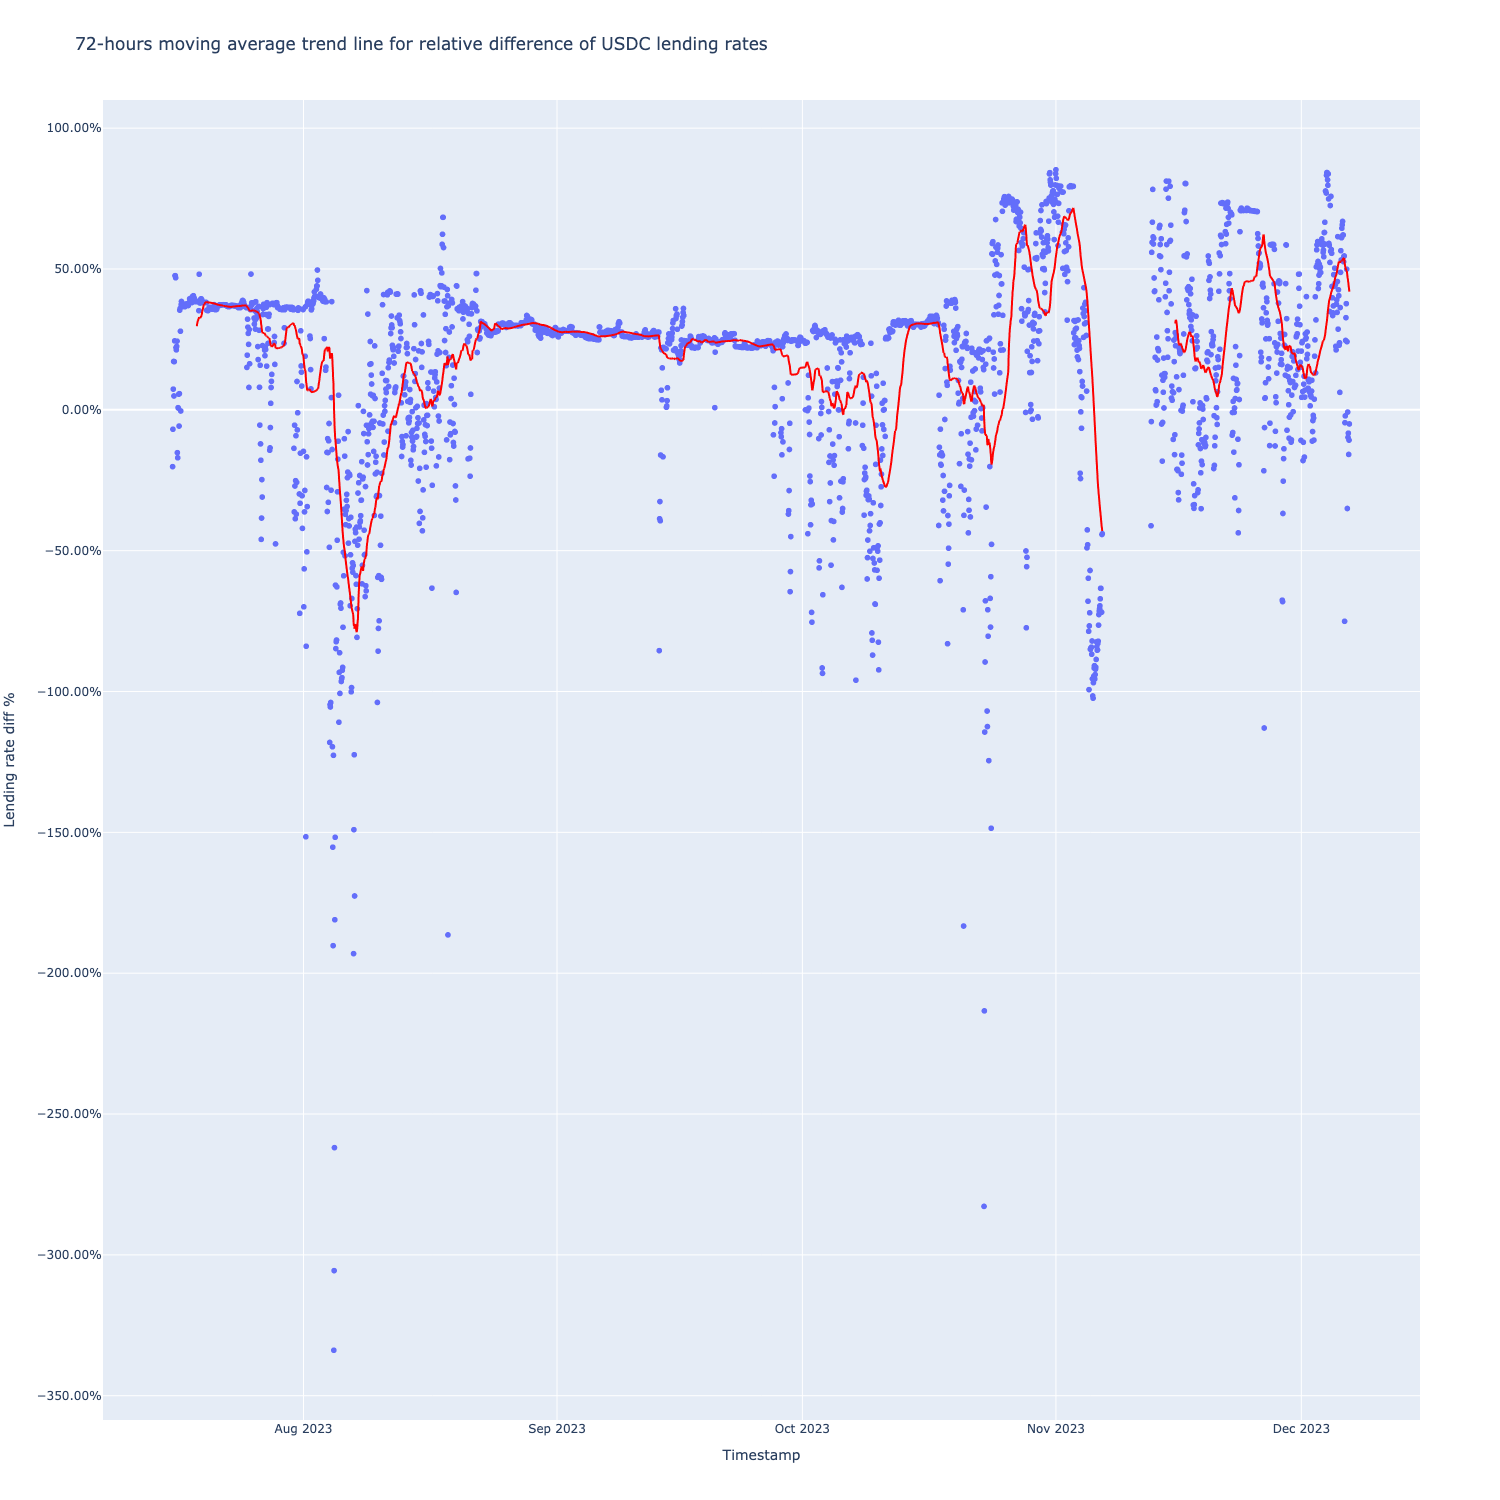

In [38]:
trend_period = 72

fig_eth = px.scatter(
    rel_diff_eth, 
    x=rel_diff_eth.index, 
    y=rel_diff_eth, 
    trendline="rolling", 
    trendline_options={"window": trend_period},
    title=f"{trend_period}-hours moving average trend line for relative difference of ETH lending rates")

# Set the trend line colour
# https://community.plotly.com/t/how-can-i-change-the-color-of-trendline/43432
fig_eth.data[1].update(line_color="red")

fig_eth.update_yaxes(title="Lending rate diff %")
fig_eth.update_xaxes(title="Timestamp")
fig_eth.layout.yaxis.tickformat = ',.2%'

fig_eth.show()

fig_usdc = px.scatter(
    rel_diff_usdc, 
    x=rel_diff_usdc.index, 
    y=rel_diff_usdc, 
    trendline="rolling", 
    trendline_options={"window": trend_period},
    title=f"{trend_period}-hours moving average trend line for relative difference of USDC lending rates")

# Set the trend line colour
# https://community.plotly.com/t/how-can-i-change-the-color-of-trendline/43432
fig_usdc.data[1].update(line_color="red")

fig_usdc.update_yaxes(title="Lending rate diff %")
fig_usdc.update_xaxes(title="Timestamp")
fig_usdc.layout.yaxis.tickformat = ',.2%'

fig_usdc.show()

# Analyse late trendline

Remove anomalies by looking only recent data.

- At the creation on WBTC-USDC pool it is likely there were fewer market markets present
- Look the charts above, and choose a time point where one belives market making become more established

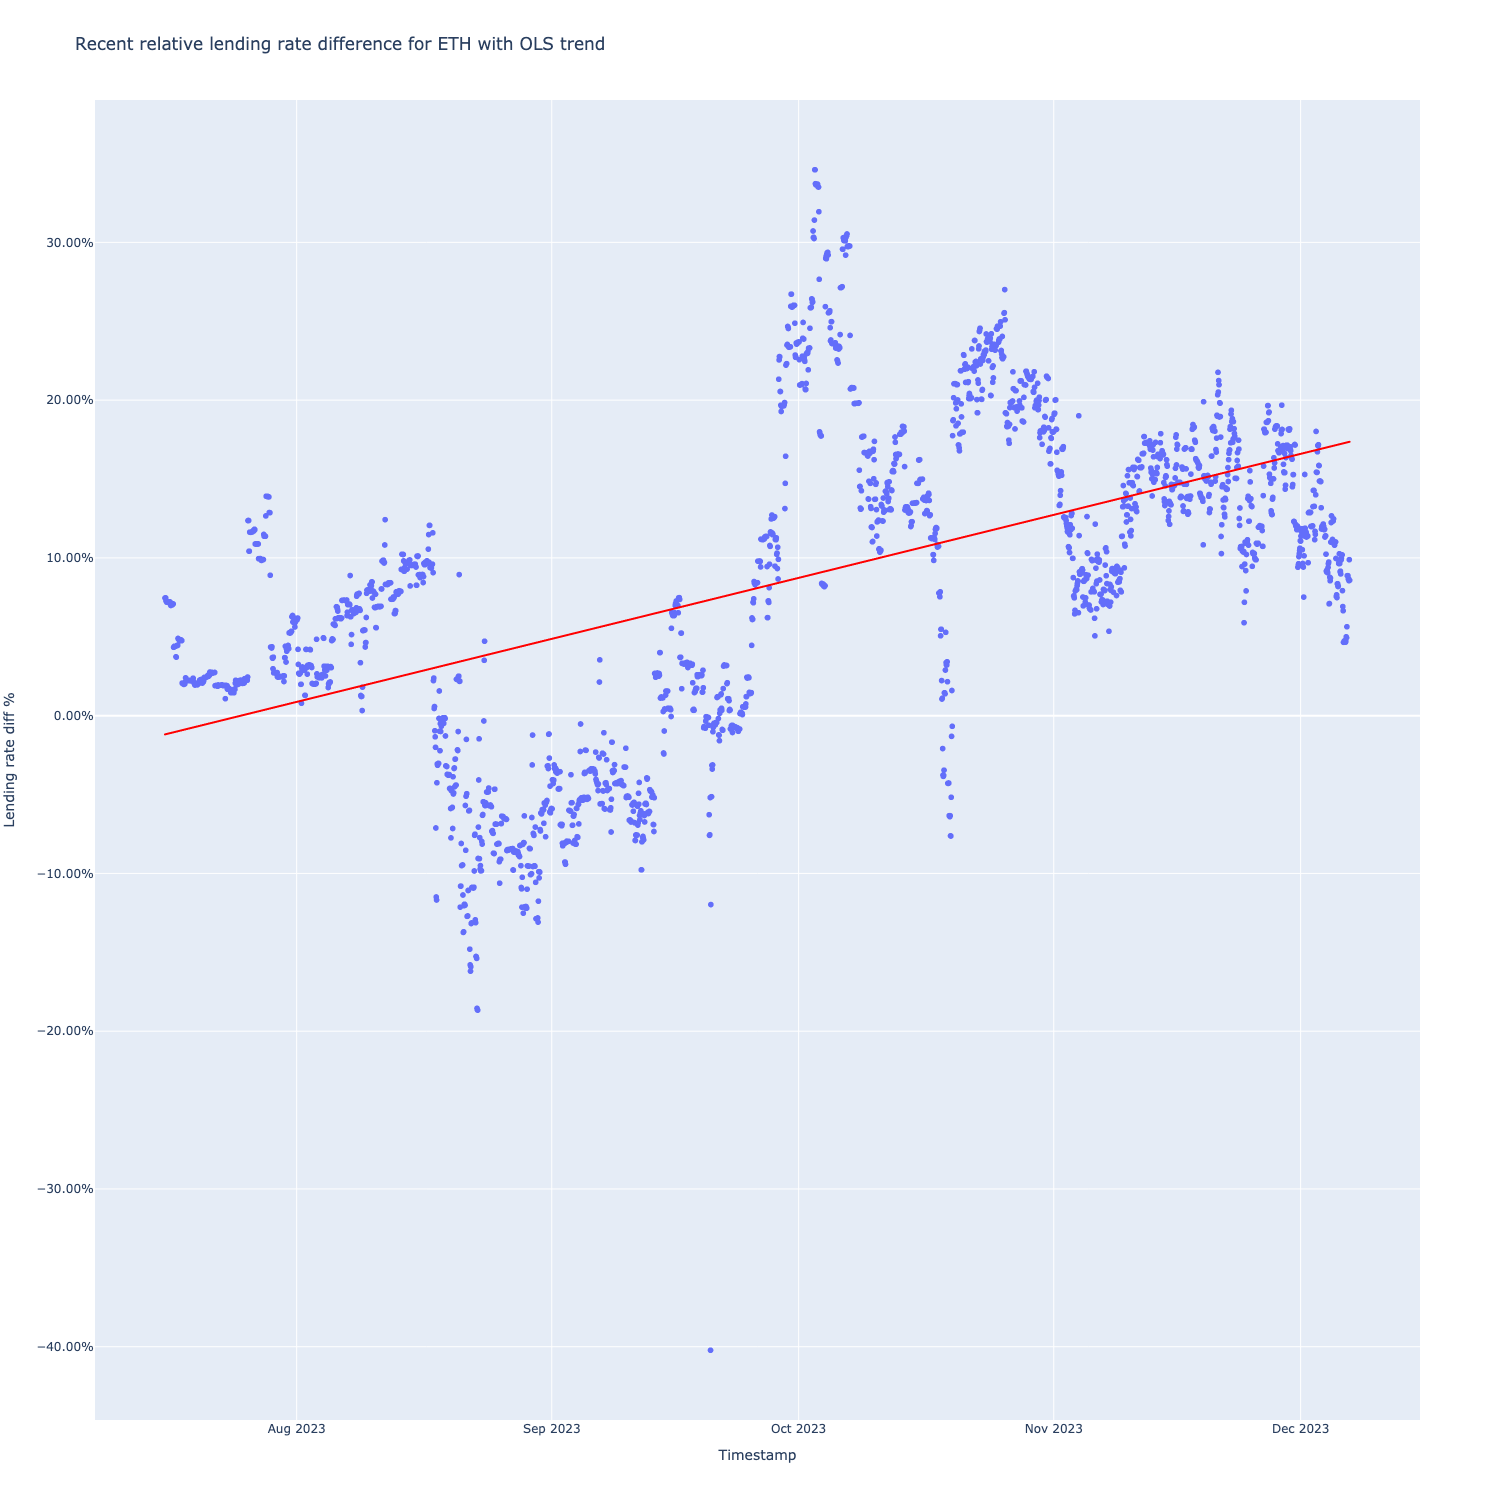

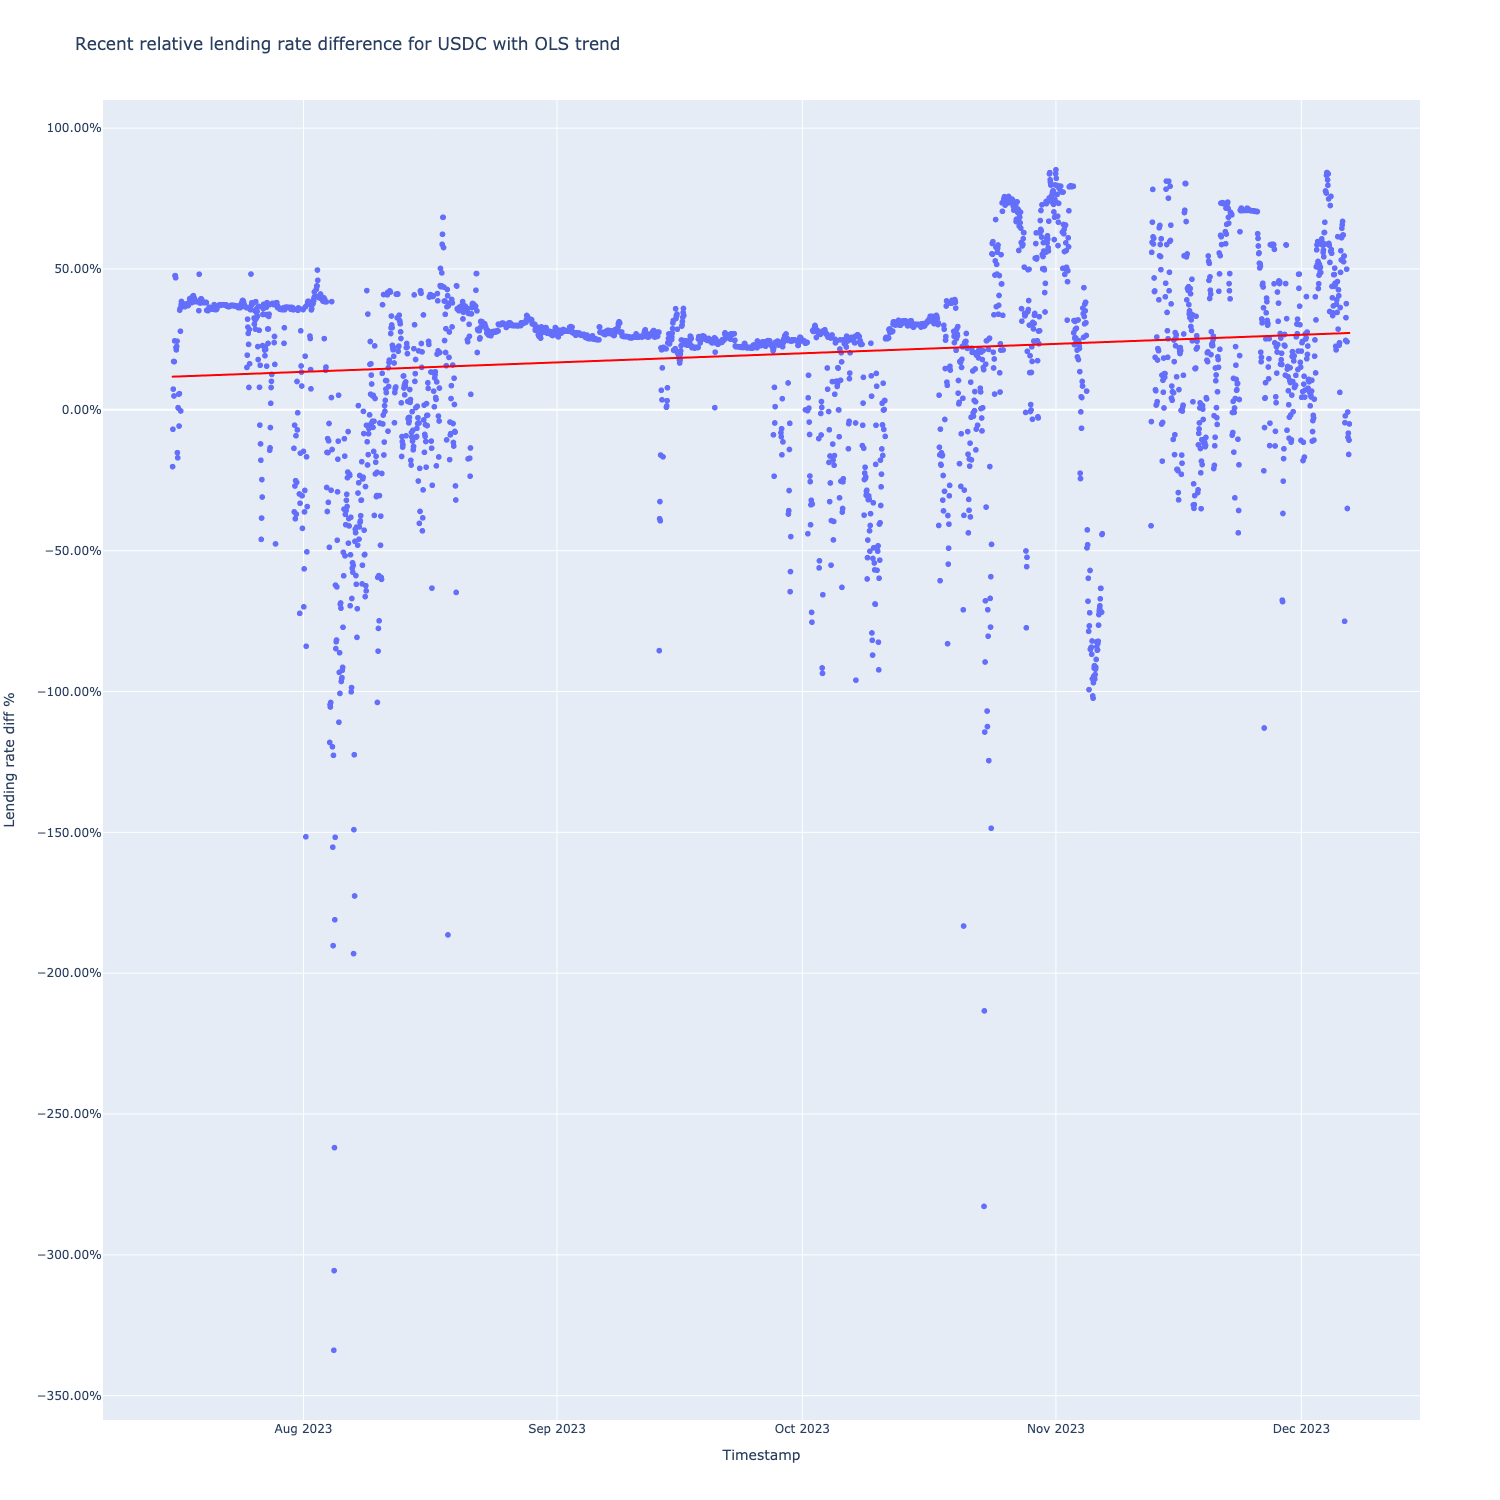

In [39]:
cut_off = pd.Timestamp("2023-04-01")

close_diff_eth = close_diff_eth[cut_off:]

rel_diff_eth = close_diff_eth / binance_candles_eth["close"]

fig_eth = px.scatter(
    rel_diff_eth,
    y=rel_diff_eth,
    x=rel_diff_eth.index,
    title="Recent relative lending rate difference for ETH with OLS trend",
    trendline="ols",
)

fig_eth.data[1].update(line_color="red")

fig_eth.update_yaxes(title="Lending rate diff %")
fig_eth.update_xaxes(title="Timestamp")
fig_eth.layout.yaxis.tickformat = ',.2%'

fig_eth.show()


close_diff_usdc = close_diff_usdc[cut_off:]

rel_diff_usdc = close_diff_usdc / binance_candles_usdc["close"]

fig_usdc = px.scatter(
    rel_diff_usdc,
    y=rel_diff_usdc,
    x=rel_diff_usdc.index,
    title="Recent relative lending rate difference for USDC with OLS trend",
    trendline="ols",
)

fig_usdc.data[1].update(line_color="red")

fig_usdc.update_yaxes(title="Lending rate diff %")
fig_usdc.update_xaxes(title="Timestamp")
fig_usdc.layout.yaxis.tickformat = ',.2%'

fig_usdc.show()
